This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $S$
    * Ionizing luminosity: $L(\mathrm{H\alpha})$
    * Distance: $d$
    * Velocity dispersion on line of sigth: $\sigma_{\text{los}}$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma_{\text{pos}}$
    * Velocity autocorrelation length scale: $r_0$
    * Structure function slope in inertial range: $m$


In [1]:
import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle
import math


Basic parameter table

In [2]:
Region =["NGC 604","NGC 595","Hubble X","Hubble V","30Dor" ,"Carina","NGC 346","M8"   ,"OrionL","OrionS"]

LHa    =[2.63e39  ,8.91e38  ,1.62e38   ,1.99e38   ,2.93e39 ,3.5e38  ,6e38     ,3e37   ,1.51e37 ,1.51e37 ]
LHaer  =[2.63e38  ,8.91e37  ,1.62e37   ,1.99e37   ,2.93e38 ,3.58e37 ,6e37     ,3e36   ,1.51e36 ,1.51e36 ]

Diam   =[400      ,400      ,160       ,130       ,370     ,200     ,220      ,25     ,5       ,5       ]
Diamer =[40       ,40       ,16        ,13        ,37      ,20      ,22       ,2.5    ,0.5     ,0.5     ]

Dist   =[840      ,840      ,500       ,500       ,50      ,2.35    ,61.7     ,1.25   ,0.4     ,0.4     ]
Dister =[30       ,30       ,40        ,40        ,0.19    ,0.05    ,1.1      ,0.1    ,0.02    ,0.02    ]

siglos =[16.21   ,18.33    ,12.3      ,13.4      ,31.7    ,22.46   ,10.1     ,13.6   ,6       ,6       ]
sigloser=[7.7     ,5.7      ,1.23      ,1.34      ,3.17    ,2.7     ,1.01     ,0.8    ,1       ,1       ]

#sigW   =[23.1     ,27.1     ,13.4      ,14.7      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]
SFR    =[5.3e-3   ,2.6e-3   ,3.1e-4    ,1.5e-4    ,1.3e-2  ,1.0e-2  ,0.0021   ,1.0e-4 ,5.3e-5  ,5.3e-5  ]
n      =[3        ,4        ,5         ,8         ,250     ,500     ,100      ,60     ,150     ,4000    ] 

Load results

In [3]:
samples=pd.read_csv('Results//file-names.csv',header=None)

CI = {}

for i in range(len(samples)):
    pickle_in = open('Results//CI' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    CI[samples[0][i]] = df

SF = {}

for i in range(len(samples)):
    pickle_in = open('Results//SF' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    SF[samples[0][i]] = df

In [4]:
samples

,0
0,N604H
1,N595
2,HX
3,HV
4,Dor
5,CarC
6,N346
7,M8
8,OrionLH
9,OrionS


## Results to table

Create the columns for the values

In [5]:
#sigma
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]
#velocity dispersion with 2-sig intervals
sig2 = [[0]*(1) for i in range(len(samples))]
sig2er = [[0]*(1) for i in range(len(samples))]
sig2s2 = [[0]*(1) for i in range(len(samples))]
sig2s2p = [[0]*(1) for i in range(len(samples))]
sig2s2m = [[0]*(1) for i in range(len(samples))]
#correlation length with 2-sig intervals
r0 = [[0]*(1) for i in range(len(samples))]
r0er = [[0]*(1) for i in range(len(samples))]
r0s2 = [[0]*(1) for i in range(len(samples))]
r0s2p = [[0]*(1) for i in range(len(samples))]
r0s2m = [[0]*(1) for i in range(len(samples))]
#power-law
m = [[0]*(1) for i in range(len(samples))]
mer = [[0]*(1) for i in range(len(samples))]
ms2 = [[0]*(1) for i in range(len(samples))]
ms2p = [[0]*(1) for i in range(len(samples))]
ms2m = [[0]*(1) for i in range(len(samples))]
#noise with 2-sig intervals
n = [[0]*(1) for i in range(len(samples))]
ner = [[0]*(1) for i in range(len(samples))]
b0s2 = [[0]*(1) for i in range(len(samples))]
b0s2p = [[0]*(1) for i in range(len(samples))]
b0s2m = [[0]*(1) for i in range(len(samples))]
#seeing with 2-sig intervals
s0 = [[0]*(1) for i in range(len(samples))]
s0er = [[0]*(1) for i in range(len(samples))]
s0s2 = [[0]*(1) for i in range(len(samples))]
s0s2p = [[0]*(1) for i in range(len(samples))]
s0s2m = [[0]*(1) for i in range(len(samples))]
#box sizes 2-sig intervals
box_sizes = [[0]*(1) for i in range(len(samples))]
box_sizes_int = [[0]*(1) for i in range(len(samples))]
box_sizeser = [[0]*(1) for i in range(len(samples))]
deltabox = [[0]*(1) for i in range(len(samples))]
boxr0ratio = [[0]*(1) for i in range(len(samples))]
boxr0ratio_int = [[0]*(1) for i in range(len(samples))]

pc = [[0]*(1) for i in range(len(samples))]


Create 2-sigma confidence intervals

In [6]:
for i in range(len(samples)):
    sig2s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['sig2'],[2.5, 97.5])
    r0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['r0'],[2.5, 97.5])
    ms2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['m'],[2.5, 97.5])
    s0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['s0'],[2.5, 97.5])
    b0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['noise'],[2.5, 97.5])

Results to empty columns

LM

In [7]:
for i in range(len(samples)):    
#for i in [0,2,4,5,6,9]:
    sig[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value,3)**0.5
    siger[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,3)**0.5
    
    sig2[i] = int(np.round(CI[samples[0][i]]['result'].params['sig2'].value,2))
    sig2er[i] = int(np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,2))
    sig2s2p[i] = np.round(sig2s2[i][1]-CI[samples[0][i]]['result'].params['sig2'].value,4)
    sig2s2m[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value-sig2s2[i][0],4)
    
    r0[i] = np.round(CI[samples[0][i]]['result'].params['r0'].value,3)
    r0er[i] = np.round(CI[samples[0][i]]['result'].params['r0'].stderr,3)
    r0s2p[i] = np.round(r0s2[i][1]-CI[samples[0][i]]['result'].params['r0'].value,4)
    r0s2m[i] = np.round(CI[samples[0][i]]['result'].params['r0'].value-r0s2[i][0],4)
    
    m[i] = np.round(CI[samples[0][i]]['result'].params['m'].value,2)
    mer[i] = np.round(CI[samples[0][i]]['result'].params['m'].stderr,1)
    ms2p[i] = np.round(ms2[i][1]-CI[samples[0][i]]['result'].params['m'].value,4)
    ms2m[i] = np.round(CI[samples[0][i]]['result'].params['m'].value-ms2[i][0],4)
    
    n[i] = np.round(CI[samples[0][i]]['result'].params['noise'].value,2)
    ner[i] = np.round(CI[samples[0][i]]['result'].params['noise'].stderr,2)
    b0s2p[i] = np.round(b0s2[i][1]-CI[samples[0][i]]['result'].params['noise'].value,4)
    b0s2m[i] = np.round(CI[samples[0][i]]['result'].params['noise'].value-b0s2[i][0],4)
    
    s0[i] = np.round(CI[samples[0][i]]['result'].params['s0'].value,3)
    s0er[i] = np.round(CI[samples[0][i]]['result'].params['s0'].stderr,3)
    s0s2p[i] = np.round(s0s2[i][1]-CI[samples[0][i]]['result'].params['s0'].value,4)
    s0s2m[i] = np.round(CI[samples[0][i]]['result'].params['s0'].value-s0s2[i][0],4)
    
    box_sizes[i] = np.round(CI[samples[0][i]]['box_size'],2)
    deltabox[i] =  CI[samples[0][i]]['r'].max()-CI[samples[0][i]]['box_size']
    pc[i] = SF[samples[0][i]]['pc']
    boxr0ratio[i] = box_sizes[i]/r0[i]

MCMC

for i in [1,3,5,7,8]:
    sig[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value,3)**0.5
    siger[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].stderr,3)**0.5
    
    sig2[i] = int(np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value,2))
    sig2er[i] = int(np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].stderr,2))
    sig2s2p[i] = np.round(sig2s2[i][1]-CI[samples[0][i]]['result_emcee'].params['sig2'].value,4)
    sig2s2m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value-sig2s2[i][0],4)
    
    r0[i] = np.round(CI[samples[0][i]]['result_emcee'].params['r0'].value,3)
    r0er[i] = np.round(CI[samples[0][i]]['result_emcee'].params['r0'].stderr,3)
    r0s2p[i] = np.round(r0s2[i][1]-CI[samples[0][i]]['result_emcee'].params['r0'].value,4)
    r0s2m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['r0'].value-r0s2[i][0],4)
    
    m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['m'].value,2)
    mer[i] = np.round(CI[samples[0][i]]['result_emcee'].params['m'].stderr,2)
    ms2p[i] = np.round(ms2[i][1]-CI[samples[0][i]]['result_emcee'].params['m'].value,4)
    ms2m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['m'].value-ms2[i][0],4)
    
    n[i] = np.round(CI[samples[0][i]]['result_emcee'].params['noise'].value,2)
    ner[i] = np.round(CI[samples[0][i]]['result_emcee'].params['noise'].stderr,2)
    b0s2p[i] = np.round(b0s2[i][1]-CI[samples[0][i]]['result_emcee'].params['noise'].value,4)
    b0s2m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['noise'].value-b0s2[i][0],4)
    
    s0[i] = np.round(CI[samples[0][i]]['result_emcee'].params['s0'].value,3)
    s0er[i] = np.round(CI[samples[0][i]]['result_emcee'].params['s0'].stderr,3)
    s0s2p[i] = np.round(s0s2[i][1]-CI[samples[0][i]]['result_emcee'].params['s0'].value,4)
    s0s2m[i] = np.round(CI[samples[0][i]]['result_emcee'].params['s0'].value-s0s2[i][0],4)
    
    box_sizes[i] = np.round(CI[samples[0][i]]['box_size'],2)
    deltabox[i] =  CI[samples[0][i]]['r'].max()-CI[samples[0][i]]['box_size']
    pc[i] = SF[samples[0][i]]['pc']
    boxr0ratio[i] = box_sizes[i]/r0[i]

In [8]:
#pc[8]=pc[8]/60

In [9]:
for i in range(len(samples)):
     box_sizes_int[i] = int(np.round(CI[samples[0][i]]['box_size'],2))
     boxr0ratio_int[i] = int(np.rint(box_sizes[i]/r0[i]))

Crate table with standar errors

In [10]:
td = pd.DataFrame(
    {
       "A": sig2,
       "DA": sig2er,
       "B": m,
       "DB": mer,
       "C": r0,
       "DC": r0er,
       "E": n,
       "DE": ner,
       "F": s0,
       "DF": s0er,
        "G":  box_sizes_int,
        "H": boxr0ratio_int,
        "I": np.round((np.array(s0)*2.35)/np.array(pc),1),
        "DI": np.round((np.array(s0er)*2.35)/np.array(pc),1),
    },
)

In [11]:
td=td.sort_values( by='A', ascending=False)

In [12]:
tdx=(td.groupby(td.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply('$\pm$'.join, 1)))
SFres=tdx[['A','E','F','C','G','B','H','I']].copy()

In [13]:
SFres.rename(columns={'A':'$\sigma^2$ [km$^2$/s$^2$]','E':'$B_{noise}$ [km$^2$/s$^2$]','B':'$m$','C':'$r_0$ [pc]','F':'$s0$ (rms) [pc]','G':'L$_{box}$ [pc]','H':'L$_{box} / r_0$','I':'$s0$ (FMHW) [arcsec]'}, inplace=True)
SFres.insert(loc=0, column='Region', value=samples)
SFres

,Region,$\sigma^2$ [km$^2$/s$^2$],$B_{noise}$ [km$^2$/s$^2$],$s0$ (rms) [pc],$r_0$ [pc],L$_{box}$ [pc],$m$,L$_{box} / r_0$,$s0$ (FMHW) [arcsec]
4,Dor,302$\pm$14,6.15$\pm$0.96,0.168$\pm$0.029,3.976$\pm$0.357,31,0.83$\pm$0.0,8,1.6$\pm$0.3
0,N604H,85$\pm$19,0.34$\pm$0.32,2.056$\pm$1.217,12.204$\pm$2.215,173,0.78$\pm$0.3,14,1.2$\pm$0.7
1,N595,53$\pm$3,1.66$\pm$1.8,0.407$\pm$0.738,11.239$\pm$0.45,196,1.38$\pm$0.1,17,0.2$\pm$0.4
6,N346,39$\pm$1,1.35$\pm$0.18,0.074$\pm$0.011,2.225$\pm$0.195,20,0.73$\pm$0.0,9,0.6$\pm$0.1
5,CarC,20$\pm$16,2.14$\pm$48.82,0.005$\pm$3.069,1.966$\pm$0.0,19,1.0$\pm$2.1,10,1.1$\pm$698.4
2,HX,15$\pm$1,0.52$\pm$0.22,0.518$\pm$0.184,3.931$\pm$0.268,78,0.95$\pm$0.1,20,0.5$\pm$0.2
9,OrionS,12$\pm$0,0.03$\pm$0.0,0.002$\pm$0.0,0.068$\pm$0.002,0,1.07$\pm$0.0,7,2.4$\pm$0.0
3,HV,11$\pm$1,0.0$\pm$0.07,0.439$\pm$0.214,4.096$\pm$0.449,61,0.69$\pm$0.1,15,0.4$\pm$0.2
7,M8,7$\pm$3,0.44$\pm$4.11,0.007$\pm$0.725,1.035$\pm$0.109,16,1.26$\pm$0.2,16,2.7$\pm$281.1
8,OrionLH,3$\pm$28,5.83$\pm$5.04,0.001$\pm$4.417,0.529$\pm$0.202,3,1.68$\pm$0.3,6,1.2$\pm$5222.0


Crate table with confidence intervals

In [14]:
s0f = pd.DataFrame(
    {
        "s0 [rms]":s0,
       "- [rms]": s0s2m,
       "+ [rms]": s0s2p,
       "s0 [FWHM]": np.array(s0)*2.35/np.array(pc),
       "- [FWHM]": np.array(s0s2m)*2.35/np.array(pc),
       "+ [FWHM]": np.array(s0s2p)*2.35/np.array(pc),
        "b0 ":n,
       "- ": b0s2m,
       "+": b0s2p,
    }
)

s0f.insert(loc=0, column='Region', value=samples)


s0f

,Region,s0 [rms],- [rms],+ [rms],s0 [FWHM],- [FWHM],+ [FWHM],b0,-,+
0,N604H,2.056,0.7178,1.6620,1.186416,0.414207,0.959058,0.34,0.3202,0.5139
1,N595,0.407,-0.0054,0.6201,0.234859,-0.003116,0.357829,1.66,1.0849,1.7441
2,HX,0.518,0.2109,0.6354,0.502172,0.204456,0.615985,0.52,0.4445,0.6482
3,HV,0.439,0.0999,0.4515,0.425586,0.096848,0.437704,0.00,-0.0078,0.6539
4,Dor,0.168,0.0580,0.1723,1.628667,0.562278,1.670353,6.15,2.8623,2.9441
5,CarC,0.005,-0.0064,0.0103,1.137846,-1.456443,2.343962,2.14,2.1308,-1.2782
6,N346,0.074,0.0268,0.0452,0.578540,0.209525,0.353378,1.35,0.6502,0.4942
7,M8,0.007,0.0062,0.0019,2.714445,2.404223,0.736778,0.44,0.4028,0.3678
8,OrionLH,0.001,0.0005,0.0021,1.182249,0.591125,2.482724,5.83,1.9129,0.4332
9,OrionS,0.002,0.0002,0.0003,2.364499,0.236450,0.354675,0.03,0.0052,0.0047


In [15]:
s1f = pd.DataFrame(
    {
        "sig2":sig2,
       "- ": sig2s2m,
       "+ ": sig2s2p,
        "r0 ":r0,
       " - ": r0s2m,
       " +": r0s2p,
        "m ":m,
       "  -": ms2m,
       "  +": ms2p,
    }
)

s1f.insert(loc=0, column='Region', value=samples)


s1f

,Region,sig2,-,+,r0,-,+,m,-,+
0,N604H,85,10.5023,48.7711,12.204,6.2123,13.6468,0.78,0.2760,0.1894
1,N595,53,1.9210,4.6306,11.239,0.8513,0.7475,1.38,0.1501,0.0898
2,HX,15,1.3253,7.1428,3.931,1.4470,1.0232,0.95,0.4065,0.1375
3,HV,11,1.1378,3.9371,4.096,1.5677,5.3679,0.69,0.1870,0.1494
4,Dor,302,25.2290,175.3929,3.976,0.6241,7.8513,0.83,0.2747,0.0909
5,CarC,20,-11.4964,14.3177,1.966,-0.0021,0.3625,1.00,0.4987,-0.4505
6,N346,39,2.7120,12.7641,2.225,0.3072,2.0853,0.73,0.1432,0.0573
7,M8,7,1.2209,3.4339,1.035,0.1962,0.7817,1.26,0.3131,0.3296
8,OrionLH,3,0.2472,2.7825,0.529,0.0606,0.1763,1.68,0.8333,0.2451
9,OrionS,12,0.5383,0.7254,0.068,0.0043,0.0060,1.07,0.0376,0.0322


In [16]:
SFres.to_latex('sf-results-merge.tex', escape=False, caption='Main results.',index=False)

Combined tables with porperly data type

In [17]:
data = pd.DataFrame(
    {
       "Region": Region,
       "LHa": LHa,
       "LHaer": LHaer,
       "SFR": SFR,
       "n": n,
       "L [pc]": Diam,
       "Ler [pc]": Diamer,
       "Dist [kpc]": Dist,
       "Dister [kpc]": Dister,
        
       "sig2 [km/s]": sig2,
       "sig2er": sig2er,
       "sig [km/s]": sig,
       "siger": siger,
       "m": m,
       "mer": mer,
       "r0 [pc]": r0,
       "r0er": r0er,
        
       "siglos [km/s]": siglos,
       "sigloser [km/s]": sigloser,
      
    },
)

In [18]:
data.dtypes

Region              object
LHa                float64
LHaer              float64
SFR                float64
n                  float64
L [pc]               int64
Ler [pc]           float64
Dist [kpc]         float64
Dister [kpc]       float64
sig2 [km/s]          int64
sig2er               int64
sig [km/s]         float64
siger              float64
m                  float64
mer                float64
r0 [pc]            float64
r0er               float64
siglos [km/s]      float64
sigloser [km/s]    float64
dtype: object

In [19]:
data

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],sig2 [km/s],sig2er,sig [km/s],siger,m,mer,r0 [pc],r0er,siglos [km/s],sigloser [km/s]
0,NGC 604,2.630000e+39,2.630000e+38,0.005300,0.34,400,40.0,840.00,30.00,85,19,9.228218,4.469676,0.78,0.3,12.204,2.215,16.21,7.70
1,NGC 595,8.910000e+38,8.910000e+37,0.002600,1.66,400,40.0,840.00,30.00,53,3,7.281415,1.931062,1.38,0.1,11.239,0.450,18.33,5.70
2,Hubble X,1.620000e+38,1.620000e+37,0.000310,0.52,160,16.0,500.00,40.00,15,1,3.950823,1.063485,0.95,0.1,3.931,0.268,12.30,1.23
3,Hubble V,1.990000e+38,1.990000e+37,0.000150,0.00,130,13.0,500.00,40.00,11,1,3.317981,1.079352,0.69,0.1,4.096,0.449,13.40,1.34
4,30Dor,2.930000e+39,2.930000e+38,0.013000,6.15,370,37.0,50.00,0.19,302,14,17.378320,3.801973,0.83,0.0,3.976,0.357,31.70,3.17
5,Carina,3.500000e+38,3.580000e+37,0.010000,2.14,200,20.0,2.35,0.05,20,16,4.521283,4.108528,1.00,2.1,1.966,0.000,22.46,2.70
6,NGC 346,6.000000e+38,6.000000e+37,0.002100,1.35,220,22.0,61.70,1.10,39,1,6.320680,1.282965,0.73,0.0,2.225,0.195,10.10,1.01
7,M8,3.000000e+37,3.000000e+36,0.000100,0.44,25,2.5,1.25,0.10,7,3,2.717536,1.806931,1.26,0.2,1.035,0.109,13.60,0.80
8,OrionL,1.510000e+37,1.510000e+36,0.000053,5.83,5,0.5,0.40,0.02,3,28,1.898684,5.340599,1.68,0.3,0.529,0.202,6.00,1.00
9,OrionS,1.510000e+37,1.510000e+36,0.000053,0.03,5,0.5,0.40,0.02,12,0,3.558651,0.530094,1.07,0.0,0.068,0.002,6.00,1.00


## Change to log scale for most parameters

El analisis de la mayoría de las columnas sería mejor en escala logarítmica porque varían por varios ordenes de magnitud.  Entonces, hacemos una nueva versión de la tabla así. Dejamos la $m$ en escala lineal porque no varía mucho.

In [20]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er", "Ler [pc]", "Dister [kpc]","LHaer","sigloser [km/s]"]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,2.630000e+38,-2.28,-0.47,2.60,40.0,2.92,30.00,1.93,19,0.97,4.469676,0.78,0.3,1.09,2.215,1.21,7.70
1,NGC 595,38.95,8.910000e+37,-2.59,0.22,2.60,40.0,2.92,30.00,1.72,3,0.86,1.931062,1.38,0.1,1.05,0.450,1.26,5.70
2,Hubble X,38.21,1.620000e+37,-3.51,-0.28,2.20,16.0,2.70,40.00,1.18,1,0.60,1.063485,0.95,0.1,0.59,0.268,1.09,1.23
3,Hubble V,38.30,1.990000e+37,-3.82,-inf,2.11,13.0,2.70,40.00,1.04,1,0.52,1.079352,0.69,0.1,0.61,0.449,1.13,1.34
4,30Dor,39.47,2.930000e+38,-1.89,0.79,2.57,37.0,1.70,0.19,2.48,14,1.24,3.801973,0.83,0.0,0.60,0.357,1.50,3.17
5,Carina,38.54,3.580000e+37,-2.00,0.33,2.30,20.0,0.37,0.05,1.30,16,0.66,4.108528,1.00,2.1,0.29,0.000,1.35,2.70
6,NGC 346,38.78,6.000000e+37,-2.68,0.13,2.34,22.0,1.79,1.10,1.59,1,0.80,1.282965,0.73,0.0,0.35,0.195,1.00,1.01
7,M8,37.48,3.000000e+36,-4.00,-0.36,1.40,2.5,0.10,0.10,0.85,3,0.43,1.806931,1.26,0.2,0.01,0.109,1.13,0.80
8,OrionL,37.18,1.510000e+36,-4.28,0.77,0.70,0.5,-0.40,0.02,0.48,28,0.28,5.340599,1.68,0.3,-0.28,0.202,0.78,1.00
9,OrionS,37.18,1.510000e+36,-4.28,-1.52,0.70,0.5,-0.40,0.02,1.08,0,0.55,0.530094,1.07,0.0,-1.17,0.002,0.78,1.00


Uncertainties Log Space

In [21]:
logdata['Ler [pc]']=(data['Ler [pc]']/data['L [pc]'])*0.434

In [22]:
logdata['sigloser [km/s]']=(data['sigloser [km/s]']/data['siglos [km/s]'])*0.434

In [23]:
logdata['LHaer']=(data['LHaer']/data['LHa'])*0.434

In [24]:
logdata['Dister [kpc]']=(data['Dister [kpc]']/data['Dist [kpc]'])*0.434

In [25]:
logdata['mer']=(data['mer']/data['m'])*0.434

In [26]:
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434

In [27]:
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434

In [28]:
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434

Make the label text bigger on the figures

In [29]:
sns.set_context("talk")

Repeat the pair plot of correlations between columns with the log-scale quantities. Use color to indicate the distance to the regions.

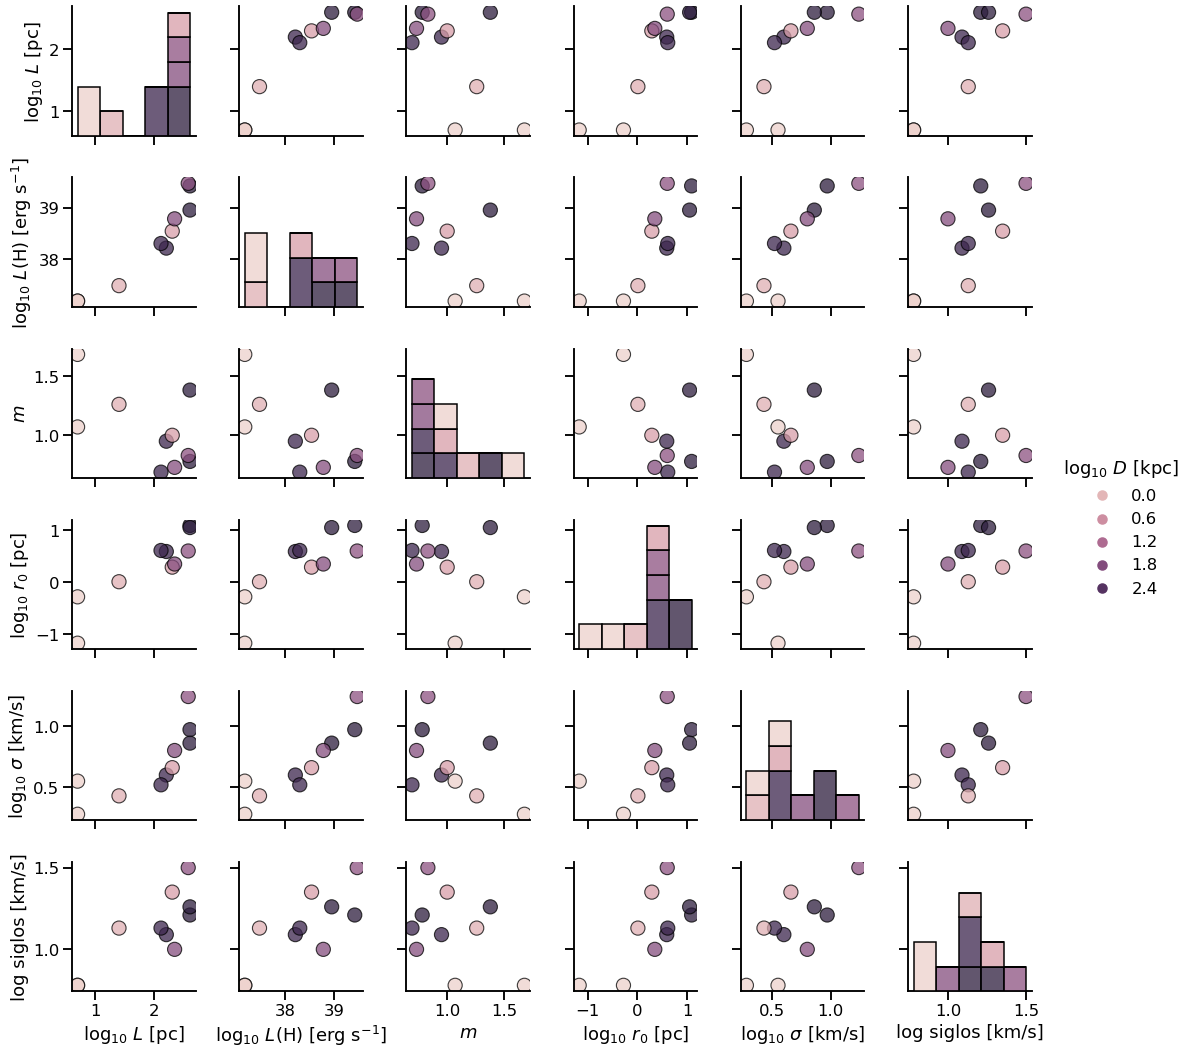

In [30]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [31]:
logdata[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
log L [pc],1.000000,0.941136,0.822637,-0.583473,0.898779,0.763588,0.817200
log L(H) [erg s^-1],0.941136,1.000000,0.745720,-0.572520,0.828776,0.904675,0.793262
log Dist [kpc],0.822637,0.745720,1.000000,-0.521569,0.869598,0.541257,0.475261
m,-0.583473,-0.572520,-0.521569,1.000000,-0.333955,-0.518864,-0.386650
log r0 [pc],0.898779,0.828776,0.869598,-0.333955,1.000000,0.564629,0.702746
log sig [km/s],0.763588,0.904675,0.541257,-0.518864,0.564629,1.000000,0.728863
log siglos [km/s],0.817200,0.793262,0.475261,-0.386650,0.702746,0.728863,1.000000


So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosity–distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values.  

## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [32]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [33]:
import scipy.stats

In [34]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)
    

In [35]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

,r,t,p
0,0.000,0.000000,5.000000e-01
1,0.200,0.540062,3.019294e-01
2,0.400,1.154701,1.407685e-01
3,0.500,1.527525,8.257494e-02
4,0.600,1.984313,4.124805e-02
5,0.700,2.593355,1.597303e-02
6,0.779,3.287020,5.535582e-03
7,0.800,3.527668,3.879201e-03
8,0.900,5.462793,2.997718e-04
9,0.908,5.733922,2.184923e-04


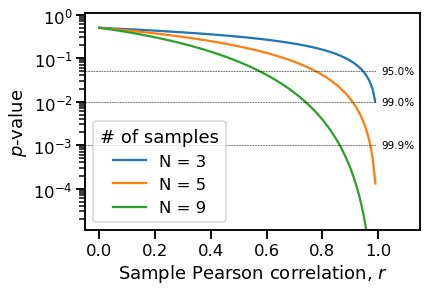

In [36]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [37]:
logdata

,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,0.043400,-2.28,-0.47,2.60,0.0434,2.92,0.015500,1.93,0.097012,0.97,0.210207,0.78,0.166923,1.09,0.078770,1.21,0.206157
1,NGC 595,38.95,0.043400,-2.59,0.22,2.60,0.0434,2.92,0.015500,1.72,0.024566,0.86,0.115099,1.38,0.031449,1.05,0.017377,1.26,0.134959
2,Hubble X,38.21,0.043400,-3.51,-0.28,2.20,0.0434,2.70,0.034720,1.18,0.028933,0.60,0.116824,0.95,0.045684,0.59,0.029588,1.09,0.043400
3,Hubble V,38.30,0.043400,-3.82,-inf,2.11,0.0434,2.70,0.034720,1.04,0.039455,0.52,0.141182,0.69,0.062899,0.61,0.047575,1.13,0.043400
4,30Dor,39.47,0.043400,-1.89,0.79,2.57,0.0434,1.70,0.001649,2.48,0.020119,1.24,0.094949,0.83,0.000000,0.60,0.038968,1.50,0.043400
5,Carina,38.54,0.044392,-2.00,0.33,2.30,0.0434,0.37,0.009234,1.30,0.347200,0.66,0.394379,1.00,0.911400,0.29,0.000000,1.35,0.052173
6,NGC 346,38.78,0.043400,-2.68,0.13,2.34,0.0434,1.79,0.007737,1.59,0.011128,0.80,0.088093,0.73,0.000000,0.35,0.038036,1.00,0.043400
7,M8,37.48,0.043400,-4.00,-0.36,1.40,0.0434,0.10,0.034720,0.85,0.186000,0.43,0.288573,1.26,0.068889,0.01,0.045706,1.13,0.025529
8,OrionL,37.18,0.043400,-4.28,0.77,0.70,0.0434,-0.40,0.021700,0.48,4.050667,0.28,1.220751,1.68,0.077500,-0.28,0.165724,0.78,0.072333
9,OrionS,37.18,0.043400,-4.28,-1.52,0.70,0.0434,-0.40,0.021700,1.08,0.000000,0.55,0.064648,1.07,0.000000,-1.17,0.012765,0.78,0.072333


In [38]:
#logdata=logdata.drop(8, axis=0)
#logdata

# Correlation between results 

r0 vs m

In [39]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','m', 'mer']]

In [40]:
Y=np.log10(Y)

In [41]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [42]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99876384 1.01521969 1.00587121 1.05684345 0.99954947 1.02534685]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00041221 0.99993618 1.00131451 1.01106824 0.99975738 1.00166304]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00299314 0.99704623 1.00014724 1.00843598 0.99902641 0.99744861]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00412443 0.99776791 0.99892112 1.00249326 0.999805   0.99762578]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00797085 0.99813138 0.99960099 0.99960438 0.99988562 0.99817375]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00310564 0.9984643  0


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00001404 0.99994078 0.99996738 1.00001973 0.99999739 0.99994076]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9999952  0.99991052 1.00004289 0.99996772 0.99999744 0.99990184]


In [43]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [44]:
#dfchain.describe()

In [45]:
pearsonr(X, Y)

(-0.35417076471861164, 0.3153378423391479)

In [46]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.314000,0.047451,-0.001399,0.136474
std,0.669896,0.046918,0.126749,0.276896
min,-1.170000,0.000000,-0.161151,0.000000
25%,0.080000,0.020430,-0.101160,0.007862
50%,0.470000,0.038502,-0.011138,0.054291
75%,0.607500,0.047108,0.082624,0.075347
max,1.090000,0.165724,0.225309,0.911400


In [47]:
#dfchain["alpha"].mean(),dfchain["beta"].mean()

In [48]:
#dfchain["alpha"].std(),dfchain["beta"].std()

[Text(0, 0.5, 'log $m$'), Text(0.5, 0, 'log $r_{0}$ [pc]')]

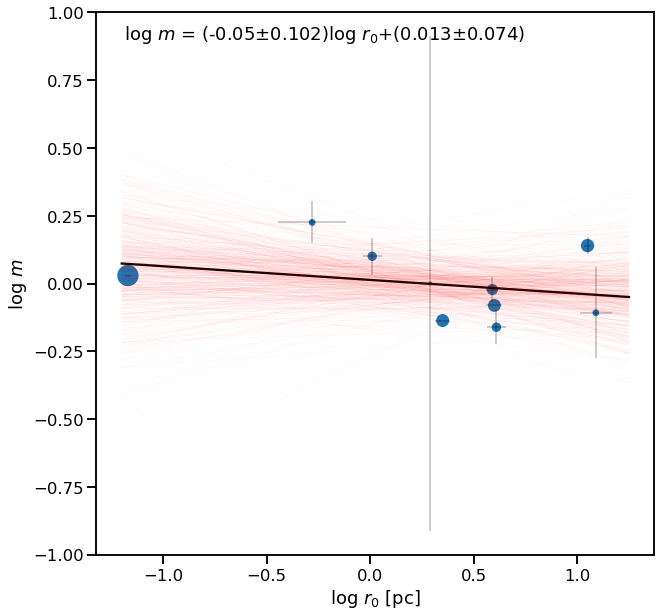

In [49]:
vmin, vmax = -1.2, 1.25
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $m$",
)

In [50]:
tab=['Y','X','a','b','r','p']

In [51]:
tab0 = ['log $m$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]

r0 vs sig

In [52]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','log sig [km/s]', 'siger']]

In [53]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [54]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.02354855 0.99313258 1.0129787  1.00133049 1.01388863 0.99522446]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00275344 0.99591906 1.00713052 1.00359574 1.00335635 1.00031002]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00252545 1.00000544 1.01954892 0.99701226 1.00155444 1.0057939 ]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00306573 1.00031086 1.00275603 1.0015177  0.99917298 1.00091256]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00143696 1.00006866 1.00188342 1.00173132 0.99980635 1.00008984]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00074713 1.00109667 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00124073 1.00028422 1.00032535 0.99998342 0.9999851  0.9998264 ]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00139346 1.00030231 1.00053377 0.99995835 0.99998539 0.99982397]


In [55]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [56]:
#dfchain.describe()

In [57]:
pearsonr(X, Y)

(0.56462936237363, 0.0890357244746629)

In [58]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.314000,0.047451,0.691000,0.273471
std,0.669896,0.046918,0.281877,0.348513
min,-1.170000,0.000000,0.280000,0.064648
25%,0.080000,0.020430,0.527500,0.099987
50%,0.470000,0.038502,0.630000,0.129003
75%,0.607500,0.047108,0.845000,0.268982
max,1.090000,0.165724,1.240000,1.220751


[Text(0, 0.5, 'log $\\sigma$ [km/s]'), Text(0.5, 0, 'log $r_{0}$ [pc]')]

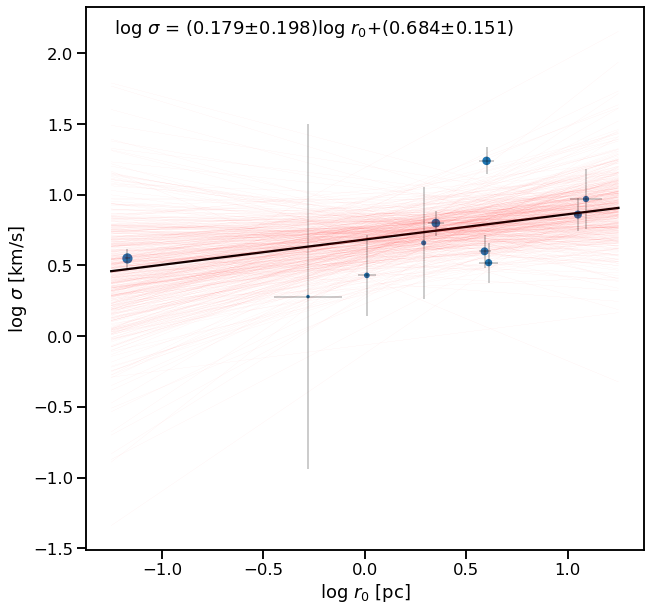

In [59]:
vmin, vmax = -1.25, 1.25
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)

    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $\sigma$ [km/s]",
)

In [60]:
tab1 = ['log $\sigma$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab1

['log $\\sigma$', 'log $r_{0}$', 0.18, 0.2, 0.68, 0.15, 0.56, 0.089]

sig vs m

In [61]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log sig [km/s]', 'siger','m', 'mer']]

In [62]:
Y=np.log10(Y)

In [63]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [64]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99189812 1.00134009 1.05345073 1.01712924 1.05508787 1.02229939]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99937787 0.99570819 1.00789911 1.00246164 1.01661937 0.99793768]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99926549 1.00008097 1.00321111 1.00165168 1.00130744 1.00092203]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00053241 1.00364787 1.0004661  1.00507418 0.99920659 1.00094112]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00184547 1.00578306 1.00579689 1.00592294 1.00117935 1.00260605]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99927583 1.00070382 1


Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00017163 1.00013849 1.00017318 0.99997902 0.99994467 1.00035791]


In [65]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [66]:
#dfchain.describe()

In [67]:
pearsonr(X, Y)

(-0.4949441411200758, 0.14582631959872308)

In [68]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.691000,0.273471,-0.001399,0.136474
std,0.281877,0.348513,0.126749,0.276896
min,0.280000,0.064648,-0.161151,0.000000
25%,0.527500,0.099987,-0.101160,0.007862
50%,0.630000,0.129003,-0.011138,0.054291
75%,0.845000,0.268982,0.082624,0.075347
max,1.240000,1.220751,0.225309,0.911400


[Text(0, 0.5, 'log $m$'), Text(0.5, 0, 'log $\\sigma$ [km/s]')]

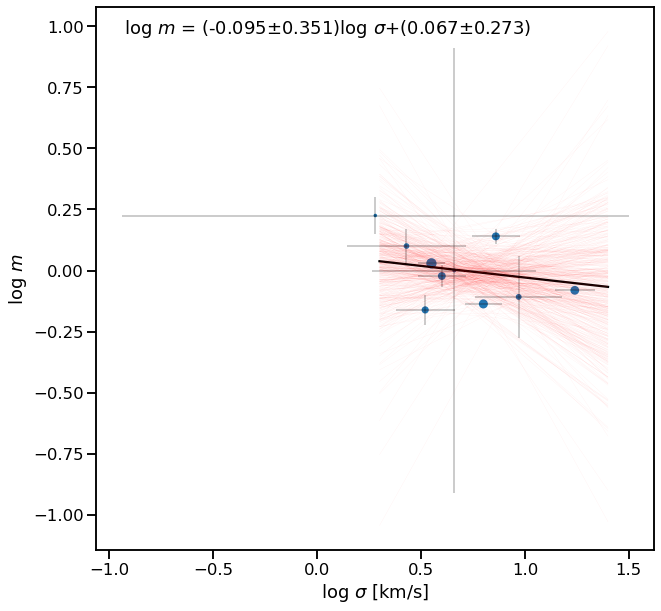

In [69]:
vmin, vmax = 0.3, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log $\sigma$ [km/s]", ylabel=r"log $m$",
)

In [70]:
tab2 = ['log $m$','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab2

['log $m$', 'log $\\sigma$', -0.1, 0.35, 0.07, 0.27, -0.49, 0.146]

# Correlation between results and HII regions properties

Diam(D) vs r0

In [71]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log r0 [pc]', 'r0er']]

In [72]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [73]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99628647 0.99227307 0.99660525 1.03442618 1.0042485  0.99955513]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99848657 0.99615378 1.00644235 1.00302285 1.00201158 1.03157614]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00055927 0.99892594 0.99888686 1.00525635 1.00041705 1.00949621]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00084278 1.00097507 1.00167371 1.00924478 1.00075244 1.00816654]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00092727 1.00047573 1.0044161  1.00524469 1.00052833 1.00708543]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00013244 0.99984605 1


Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99990712 0.99994422 0.99982784 0.99992485 1.00001879 1.00002862]


In [74]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [75]:
#dfchain.describe()

In [76]:
pearsonr(X, Y)

(0.8987786312296933, 0.00040580212021508515)

In [77]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.0000,10.000000,10.000000
mean,1.952000,0.0434,0.314000,0.047451
std,0.746812,0.0000,0.669896,0.046918
min,0.700000,0.0434,-1.170000,0.000000
25%,1.577500,0.0434,0.080000,0.020430
50%,2.250000,0.0434,0.470000,0.038502
75%,2.512500,0.0434,0.607500,0.047108
max,2.600000,0.0434,1.090000,0.165724


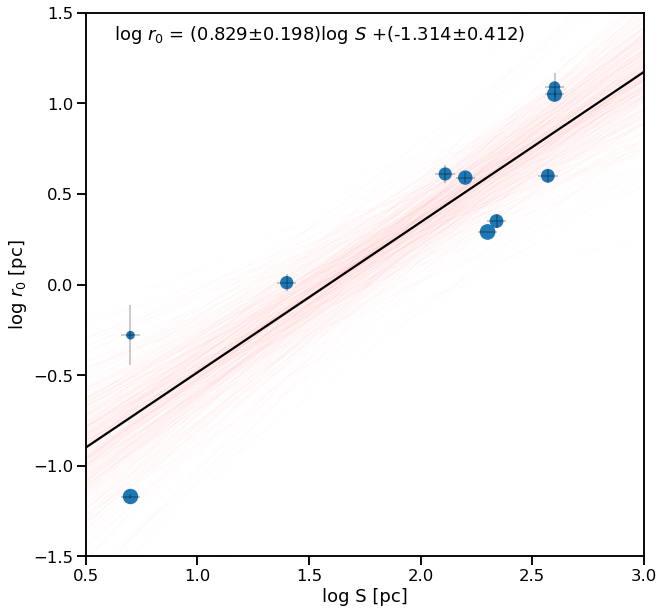

In [78]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))


# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k",zorder=10)
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.10, lw=0.1,zorder=0)
    
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=6)
ax.scatter(X, Y, marker=".", s=35/np.hypot(Xe, Ye),zorder=5)
    
ax.text(.05, .95,'log $r_0$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $S$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.5, 3], ylim=[-1.5, 1.5],
    xlabel=r"log S [pc]", ylabel=r"log $r_0$ [pc]",
)

plt.savefig('Imgs//corr-rvsS.pdf', bbox_inches='tight')


In [79]:
tab3 = ['log $r_0$','log $S$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab3

['log $r_0$', 'log $S$', 0.83, 0.2, -1.31, 0.41, 0.9, 0.0]

In [80]:
10**X/10**Y

0     32.359366
1     35.481339
2     40.738028
3     31.622777
4     93.325430
5    102.329299
6     97.723722
7     24.547089
8      9.549926
9     74.131024
dtype: float64

box size vs r0 
In this case the errors for the analysis are given by the eq: boxsize-max value of separation r

In [81]:
Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er']]

In [82]:
X = np.log10(box_sizes)

In [83]:
for i in range(len(samples)):
    box_sizeser[i]=(deltabox[i]/box_sizes[i])*0.434

In [84]:
Xe = box_sizeser
Xe

[0.09464491465440843,
 0.033143005626679475,
 0.07266700504603697,
 0.06732368052045992,
 0.09637568835255053,
 -0.06001180910619889,
 0.08045096671076757,
 0.10915901487051224,
 0.09547768780875168,
 0.07516179621489098]

In [85]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [86]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00603271 0.99595252 1.02798065 1.01896096 1.00028287 1.02848043]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00529153 1.00541369 1.01636894 0.99518968 1.0000087  1.0118213 ]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00289758 1.00538711 1.00095307 0.9977893  0.99993252 1.00221702]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00292336 1.00398037 1.01134289 1.0000347  1.0011015  1.00793494]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0014637  1.00091022 1.01206427 1.00109218 0.99995059 1.0045096 ]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00031786 0.99994916 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00004761 1.00002929 1.00029688 1.00012302 1.00000387 1.00033711]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00002172 1.00001737 1.00019569 1.00013075 1.00000412 1.00019319]


In [87]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [88]:
pearsonr(X, Y)

(0.9846846582983537, 2.363092345454249e-07)

In [89]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,1.365835,0.066439,0.314000,0.047451
std,0.804743,0.049183,0.669896,0.046918
min,-0.346787,-0.060012,-1.170000,0.000000
25%,1.228515,0.068660,0.080000,0.020430
50%,1.401792,0.077806,0.470000,0.038502
75%,1.865920,0.095269,0.607500,0.047108
max,2.292876,0.109159,1.090000,0.165724


[Text(0, 0.5, 'log $r_0$ [pc]'), Text(0.5, 0, 'log box_size [pc]')]

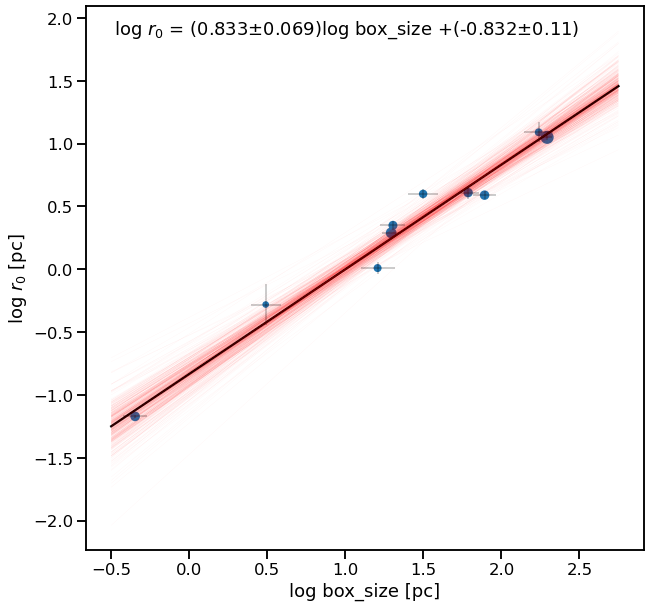

In [90]:
vmin, vmax = -0.5, 2.75
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.1)
    
ax.text(.05, .95,'log $r_0$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log box_size +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log box_size [pc]", ylabel=r"log $r_0$ [pc]",
)

#plt.savefig('Imgs//rvsR.pdf', bbox_inches='tight')


In [91]:
10**X/10**Y

0    14.097732
1    17.493473
2    20.056798
3    15.027728
4     7.914954
5    10.082855
6     9.018542
7    15.733519
8     5.887874
9     6.655988
Name: log r0 [pc], dtype: float64

L vs sig

In [92]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [93]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [94]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.02033429 1.02166109 1.12816381 1.00857514 0.99820214 1.12183426]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00059856 1.00036865 1.03690943 1.00928133 0.99851767 1.0220629 ]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99785493 0.99772572 1.03314666 1.00091887 0.99970856 1.01614207]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00074793 1.00058506 1.02130148 0.99761421 1.00302854 1.00489995]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99873049 0.99869347 1.01852813 0.99899053 1.00236232 1.00396613]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00217394 1.00221595 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00043925 1.00044754 1.00344005 1.00003938 0.99996268 1.00091993]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00066047 1.00066903 1.00351485 1.00007978 0.99996343 1.00102148]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00068983 1.00069491 1.00327811 1.00007873 0.99996594 1.00089669]


In [95]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [96]:
pearsonr(X, Y)

(0.9046750027377901, 0.0003215436562646281)

In [97]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,38.351000,0.043499,0.691000,0.273471
std,0.849646,0.000314,0.281877,0.348513
min,37.180000,0.043400,0.280000,0.064648
25%,37.662500,0.043400,0.527500,0.099987
50%,38.420000,0.043400,0.630000,0.129003
75%,38.907500,0.043400,0.845000,0.268982
max,39.470000,0.044392,1.240000,1.220751


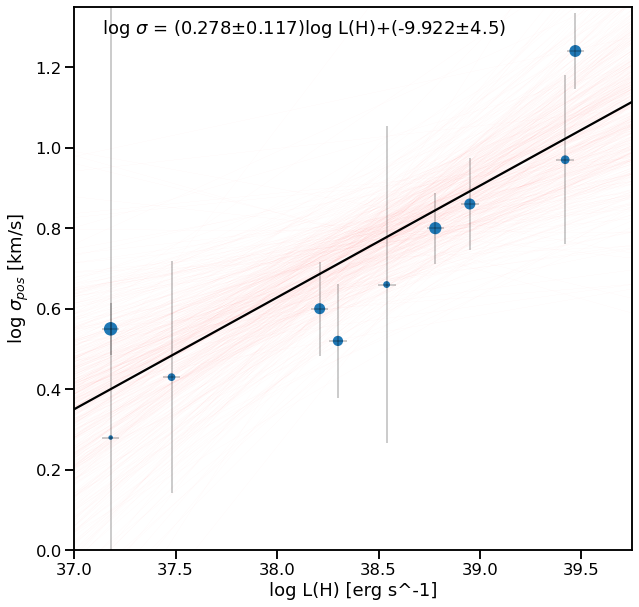

In [98]:
vmin, vmax = 36, 40
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=10)
ax.scatter(X, Y, marker=".", s=45/np.hypot(Xe, Ye),zorder=5)
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k",zorder=3)
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.10, lw=0.1,zorder=0)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log L(H)+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[37, 39.75], ylim=[0, 1.35],
    xlabel=r"log L(H) [erg s^-1]", ylabel=r"log $\sigma_{pos}$ [km/s]",
)

plt.savefig('Imgs//corr-svsL.pdf', bbox_inches='tight')


In [99]:
tab4 = ['log $\sigma$','log L(H)',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab4

['log $\\sigma$', 'log L(H)', 0.28, 0.12, -9.92, 4.5, 0.9, 0.0]

In [100]:
Y, Ye, X, Xe = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [101]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [102]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.04081877 1.024904   1.03284224 1.01843395 1.00107106 1.01954652]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01946004 1.01742542 1.04781085 1.00716945 0.99659003 1.03951479]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01499406 1.01149722 1.03373505 1.00170846 0.99948208 1.02781023]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0079248  1.00584868 1.02220002 1.00533327 1.00112655 1.01973421]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.004306   1.00497157 1.01699727 1.00550448 1.0008767  1.01670774]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00814491 1.00877527 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00081626 1.00050238 1.00043456 1.00201741 0.99986789 1.00042921]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00064262 1.00031586 1.00042205 1.00233421 0.99987099 1.00041587]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00049871 1.00021067 1.00055861 1.00209649 0.9998781  1.0003981 ]


In [103]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [104]:
pearsonr(X, Y)

(0.9046750027377901, 0.0003215436562646281)

In [105]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.691000,0.273471,38.351000,0.043499
std,0.281877,0.348513,0.849646,0.000314
min,0.280000,0.064648,37.180000,0.043400
25%,0.527500,0.099987,37.662500,0.043400
50%,0.630000,0.129003,38.420000,0.043400
75%,0.845000,0.268982,38.907500,0.043400
max,1.240000,1.220751,39.470000,0.044392


[Text(0, 0.5, 'log L(H) [erg s^-1]'), Text(0.5, 0, 'log $\\sigma$ [km/s]')]

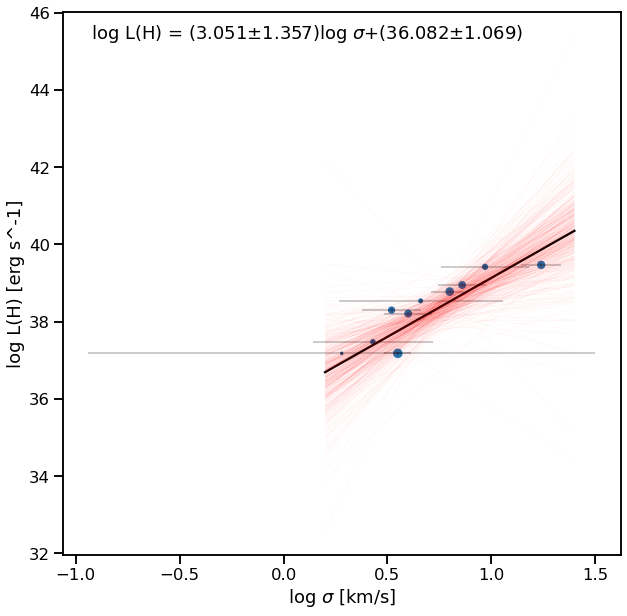

In [106]:
vmin, vmax = 0.2, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log L(H) = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    ylabel=r"log L(H) [erg s^-1]", xlabel=r"log $\sigma$ [km/s]",
)

In [107]:
tab5 = ['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab5

['log L(H)', 'log $\\sigma$', 3.05, 1.36, 36.08, 1.07, 0.9, 0.0]

Distance (D) vs m

In [108]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log Dist [kpc]', 'Dister [kpc]','m', 'mer']]

In [109]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [110]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99861805 0.99030031 1.00849924 1.02858007 1.00647709 1.0054022 ]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00317835 0.99533544 1.00529303 1.03459541 1.00390857 1.00419014]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9995472  0.99782595 1.00274539 1.0197852  1.00704018 0.99861299]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99772098 0.99893193 1.00017981 1.02039877 1.00663512 0.99907337]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99846897 0.99811238 1.00070553 1.00782255 1.00301155 0.99979718]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99967846 0.99884161 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00022443 1.00012088 1.00039794 1.00066044 1.00012538 1.00015453]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00012934 1.00007893 1.00037155 1.00104197 1.00011012 1.00006853]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00013756 1.00008247 1.00040254 1.00112785 1.00008216 1.00008833]


In [111]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [112]:
pearsonr(X, Y)

(-0.521568836159306, 0.12206256713928393)

In [113]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,1.440000,0.019718,1.037000,0.136474
std,1.392751,0.012012,0.318749,0.276896
min,-0.400000,0.001649,0.690000,0.000000
25%,0.167500,0.010801,0.792500,0.007862
50%,1.745000,0.018600,0.975000,0.054291
75%,2.700000,0.031465,1.212500,0.075347
max,2.920000,0.034720,1.680000,0.911400


[Text(0, 0.5, 'log $m$'), Text(0.5, 0, 'log Dist [kpc]')]

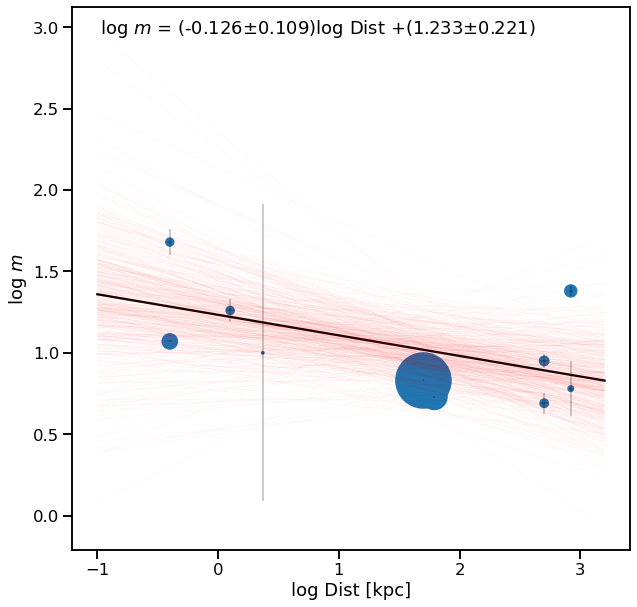

In [114]:
vmin, vmax = -1.0, 3.2
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log Dist +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log Dist [kpc]", ylabel=r"log $m$",
)

In [115]:
tab6 = ['log $m$','log Dist',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab6

['log $m$', 'log Dist', -0.13, 0.11, 1.23, 0.22, -0.52, 0.12]

sig vs siglos

In [116]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log siglos [km/s]', 'sigloser [km/s]','log sig [km/s]', 'siger']]

In [117]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [118]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.1165333  1.12238415 1.05477446 1.04864011 0.99824445 1.04769265]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0243861  1.02470133 0.99773031 1.01486236 0.99999583 1.02674185]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0079732  1.0086925  1.02239698 1.00743154 0.9999975  1.02596796]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00265167 1.00273462 1.01292425 1.00455783 0.99999268 1.00685486]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00197586 1.00205473 1.00255102 1.00854182 1.00004162 1.00607606]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998214 0.99978568 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00008593 1.00022406 1.00523892 1.00055754 0.99995223 1.00304972]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00001923 1.00014523 1.00466678 1.00042678 0.99995382 1.00279306]


In [119]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [120]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,1.123000,0.073708,0.691000,0.273471
std,0.228913,0.055535,0.281877,0.348513
min,0.780000,0.025529,0.280000,0.064648
25%,1.022500,0.043400,0.527500,0.099987
50%,1.130000,0.047786,0.630000,0.129003
75%,1.247500,0.072333,0.845000,0.268982
max,1.500000,0.206157,1.240000,1.220751


[(0.0, 1.5),
 Text(0, 0.5, 'log $\\sigma$ [km/s]'),
 (0.7, 1.6),
 Text(0.5, 0, 'log $\\sigma_{LOS}$[km/s]')]

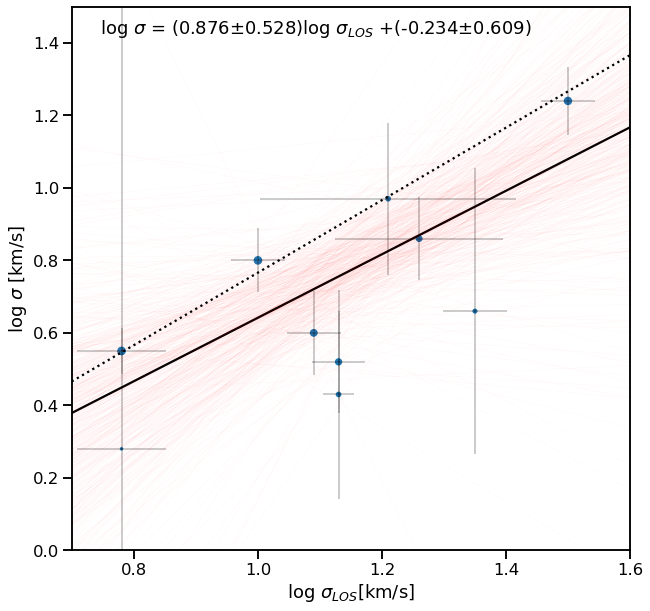

In [121]:
vmin, vmax = 0.6, 1.6
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.1)
    
ax.plot(xgrid,xgrid*1+dfchain["alpha"].mean(),linestyle=':',color='k')
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma_{LOS}$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.7, 1.6], ylim=[0.0, 1.5],
    xlabel=r"log $\sigma_{LOS}$[km/s]", ylabel=r"log $\sigma$ [km/s]",
)

#plt.savefig('Imgs//corr-svss.pdf', bbox_inches='tight')


In [122]:
tab7 = ['log $\sigma$','log $\sigma_{LOS}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab7

['log $\\sigma$', 'log $\\sigma_{LOS}$', 0.88, 0.53, -0.23, 0.61, 0.73, 0.02]

siglos vs sig

In [123]:
Y, Ye, X, Xe = [logdata[_] for _ in ['log siglos [km/s]', 'sigloser [km/s]','log sig [km/s]', 'siger']]

In [124]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [125]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0227157  1.02086304 1.16772992 1.0206791  1.00989549 1.09030414]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01366022 1.00876609 1.04432196 1.0051456  1.00177842 1.0266915 ]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01164309 1.01014828 1.05970224 1.00794646 0.99749008 1.03837895]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01645679 1.0175898  1.03991528 1.00323379 0.99785435 1.03924656]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.007609   1.0079425  1.03015029 1.00826724 0.99867122 1.03342967]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00307661 1.00346789 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00076607 1.00099085 1.00347999 0.99995519 1.00006755 1.00353118]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00077989 1.00102853 1.00330684 0.99989364 1.00006613 1.00328414]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00060986 1.00082393 1.00317504 0.99989577 1.00006495 1.00325577]


In [126]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [127]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,0.691000,0.273471,1.123000,0.073708
std,0.281877,0.348513,0.228913,0.055535
min,0.280000,0.064648,0.780000,0.025529
25%,0.527500,0.099987,1.022500,0.043400
50%,0.630000,0.129003,1.130000,0.047786
75%,0.845000,0.268982,1.247500,0.072333
max,1.240000,1.220751,1.500000,0.206157


[Text(0, 0.5, 'log $\\sigma_{LOS}$ [km/s]'),
 Text(0.5, 0, 'log $\\sigma$[km/s]')]

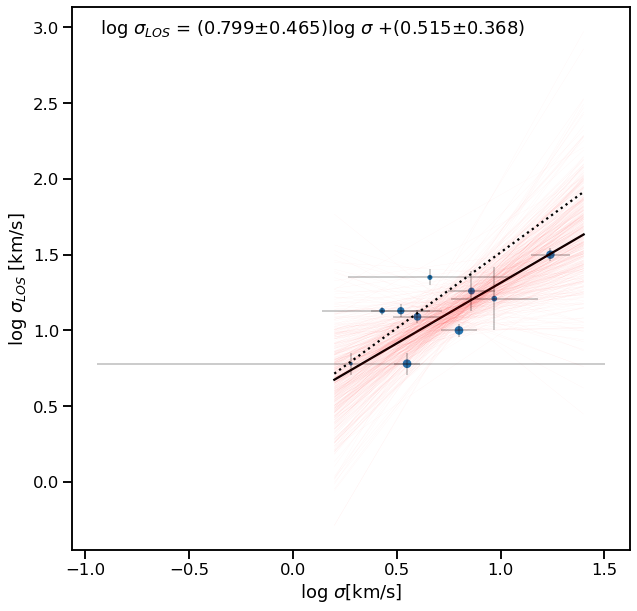

In [128]:
vmin, vmax = 0.2, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.1)
    
ax.plot(xgrid,xgrid*1+dfchain["alpha"].mean(),linestyle=':',color='k')
    
ax.text(.05, .95,'log $\sigma_{LOS}$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log $\sigma$[km/s]", ylabel=r"log $\sigma_{LOS}$ [km/s]",
)

#plt.savefig('Imgs//svss.pdf', bbox_inches='tight')


In [129]:
Y = data['siglos [km/s]']

In [130]:
Ye=data['sigloser [km/s]']

In [131]:
Y,Ye

(0    16.21
 1    18.33
 2    12.30
 3    13.40
 4    31.70
 5    22.46
 6    10.10
 7    13.60
 8     6.00
 9     6.00
 Name: siglos [km/s], dtype: float64,
 0    7.70
 1    5.70
 2    1.23
 3    1.34
 4    3.17
 5    2.70
 6    1.01
 7    0.80
 8    1.00
 9    1.00
 Name: sigloser [km/s], dtype: float64)

In [132]:
X = data['sig [km/s]']

In [133]:
Xe = data['siger']

In [134]:
X,Xe

(0     9.228218
 1     7.281415
 2     3.950823
 3     3.317981
 4    17.378320
 5     4.521283
 6     6.320680
 7     2.717536
 8     1.898684
 9     3.558651
 Name: sig [km/s], dtype: float64,
 0    4.469676
 1    1.931062
 2    1.063485
 3    1.079352
 4    3.801973
 5    4.108528
 6    1.282965
 7    1.806931
 8    5.340599
 9    0.530094
 Name: siger, dtype: float64)

<ErrorbarContainer object of 3 artists>

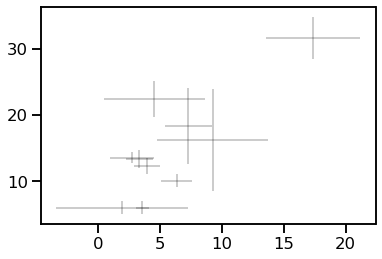

In [135]:
plt.errorbar(X, Y, xerr=Xe, yerr=Ye, ls="", elinewidth=0.4, alpha=1.0, c="k")

In [136]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [137]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.02790316 1.01689488 1.02201686 1.00688085 1.01576297 1.00160009]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.02462401 1.03163303 1.01807694 0.99673847 1.00866159 1.00639694]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0233903  1.03031636 1.00194676 1.00157438 1.00466942 1.00058758]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00616638 1.01089356 1.00842498 1.0020348  1.00001581 1.00671251]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00455958 1.00934958 1.0010344  1.00432322 1.00003772 1.00099385]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00318418 1.00735913 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00074028 1.00085082 1.0035123  1.00026675 0.99996677 1.00379468]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00066901 1.00108196 1.00390973 1.00054916 0.99997128 1.00400406]


In [138]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [139]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.000000,10.000000,10.000000
mean,6.017359,2.541466,15.010000,2.565000
std,4.579713,1.714691,7.781128,2.363971
min,1.898684,0.530094,6.000000,0.800000
25%,3.378149,1.130255,10.650000,1.002500
50%,4.236053,1.868996,13.500000,1.285000
75%,7.041231,4.031889,17.800000,3.052500
max,17.378320,5.340599,31.700000,7.700000


[Text(0, 0.5, '$\\sigma_{LOS}$ [km/s]'), Text(0.5, 0, '$\\sigma$[km/s]')]

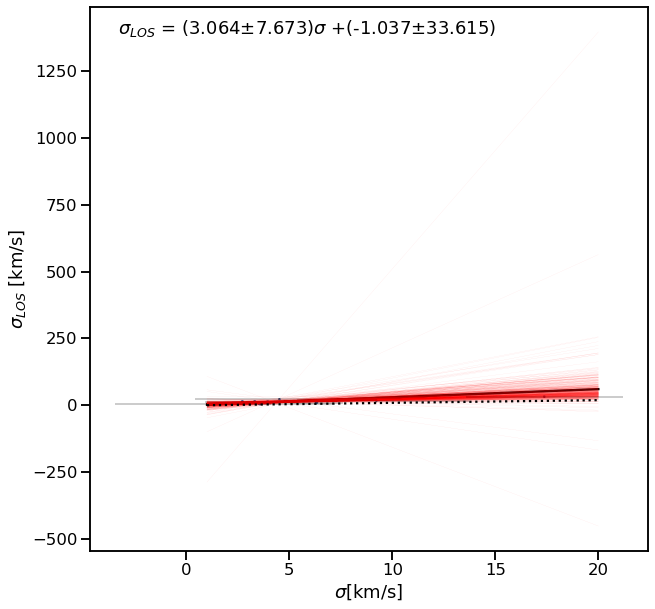

In [140]:
vmin, vmax = 1, 20
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.25, lw=0.1)
    
ax.plot(xgrid,xgrid*1+dfchain["alpha"].mean(),linestyle=':',color='k')
    
ax.text(.05, .95,'$\sigma_{LOS}$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')$\sigma$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"$\sigma$[km/s]", ylabel=r"$\sigma_{LOS}$ [km/s]",
)

#plt.savefig('Imgs//svss.pdf', bbox_inches='tight')

In [141]:
x,y,z=X,Y,Ye
XX = sm.add_constant(X)
model = sm.WLS(y, XX,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:          siglos [km/s]   R-squared:                       0.288
Model:                            WLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     3.240
Date:                Thu, 05 May 2022   Prob (F-statistic):              0.110
Time:                        11:02:14   Log-Likelihood:                -31.466
No. Observations:                  10   AIC:                             66.93
Df Residuals:                       8   BIC:                             67.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7260      2.690      2.500      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


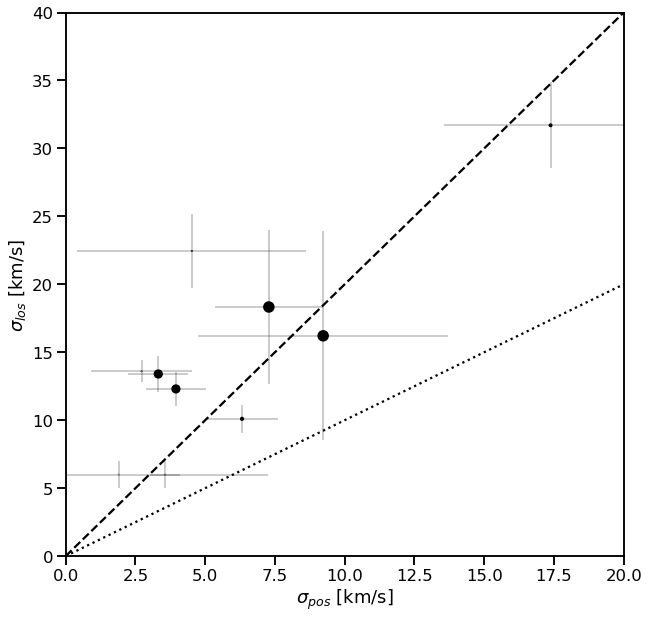

In [142]:
xgrid = np.linspace(0, 30, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls="", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, alpha=1.0, c="k", s=data['Dist [kpc]']/data['Dist [kpc]'].max()*100)

#ax.plot(xgrid,xgrid*results.params[1]+results.params[0],linestyle='-',color='k')

#ax.plot(xgrid,xgrid*(results.params[1]+results.bse[1])+(results.params[0]+results.bse[0]),linestyle=':',color='k')
#ax.plot(xgrid,xgrid*(results.params[1]-results.bse[1])+(results.params[0]-results.bse[0]),linestyle=':',color='k')
#ax.plot(xgrid,xgrid*(results.params[1]+results.bse[1])+(results.params[0]-results.bse[0]),linestyle=':',color='k')
#ax.plot(xgrid,xgrid*(results.params[1]-results.bse[1])+(results.params[0]+results.bse[0]),linestyle=':',color='k')


ax.plot(xgrid,xgrid*1+0,linestyle='dotted',color='k')
ax.plot(xgrid,xgrid*2+0,linestyle='dashed',color='k')


 
#ax.text(.05, .95,'$\sigma_{LOS}$ = (' 
#        + str(np.round(results.params[1],3)) + '$\pm$' + str(np.round(results.bse[1],3))
#        + ')$\sigma$ +('
#        + str(np.round(results.params[0],3)) + '$\pm$' + str(np.round(results.bse[0],3))
#        + ')',  color='k', transform=ax.transAxes)
        
ax.set(
    xlim=[0, 20], ylim=[0, 40],
 xlabel=r"$\sigma_{pos}$ [km/s]", ylabel=r"$\sigma_{los}$ [km/s]",
)

plt.savefig('Imgs//corr-los-vs-pos.pdf', bbox_inches='tight')

In [143]:
data['Dist [kpc]']

0    840.00
1    840.00
2    500.00
3    500.00
4     50.00
5      2.35
6     61.70
7      1.25
8      0.40
9      0.40
Name: Dist [kpc], dtype: float64

In [144]:
results.params

const         6.726034
sig [km/s]    1.089637
dtype: float64

In [145]:
results.bse

const         2.689938
sig [km/s]    0.605393
dtype: float64

sig vs S

In [146]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log sig [km/s]', 'siger']]

In [147]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [148]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99062291 0.99057453 1.07262399 0.99527304 0.99991519 1.04294008]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00035137 1.0007728  1.0184116  1.00248958 0.99998924 1.02866205]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00615155 1.0059402  1.03310688 1.01305567 0.99999475 1.02196297]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00673195 1.00606805 1.0145144  1.00936506 0.99999555 1.00920444]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0015634  1.00093465 1.00910444 1.00220479 0.99999687 1.00194862]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00055171 1.00002761 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00139724 1.00142539 1.00183334 0.99992337 1.00001627 1.00073221]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00154048 1.00162294 1.00192151 0.99993622 1.00001594 1.00084476]


In [149]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [150]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,10.000000,10.0000,10.000000,10.000000
mean,1.952000,0.0434,0.691000,0.273471
std,0.746812,0.0000,0.281877,0.348513
min,0.700000,0.0434,0.280000,0.064648
25%,1.577500,0.0434,0.527500,0.099987
50%,2.250000,0.0434,0.630000,0.129003
75%,2.512500,0.0434,0.845000,0.268982
max,2.600000,0.0434,1.240000,1.220751


[Text(0, 0.5, '$\\sigma$ [km/s]'), Text(0.5, 0, '$S$[km/s]')]

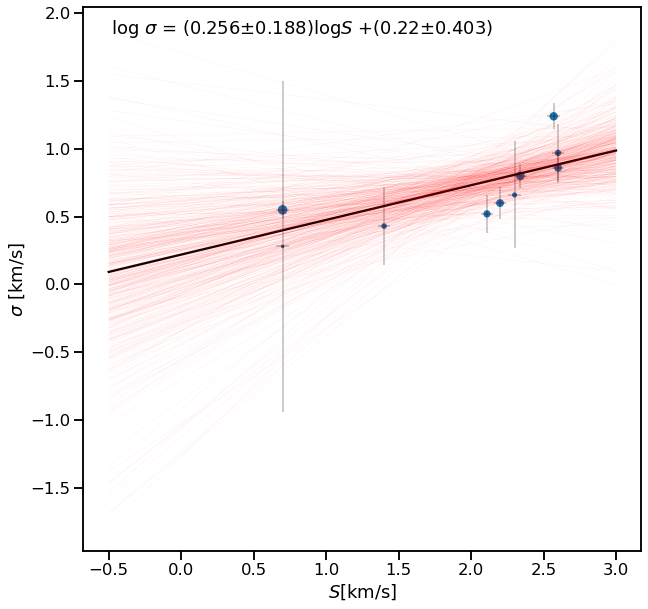

In [151]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.25, lw=0.1)
    
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log$S$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"$S$[km/s]", ylabel=r"$\sigma$ [km/s]",
)

#plt.savefig('Imgs//svss.pdf', bbox_inches='tight')

In [152]:
Corr = pd.DataFrame([tab0, tab1,tab2,tab3,tab4,tab6,tab7])
Corr.rename(columns={0:'A',1:'B',2:'C',3:'DC',4:'E',5:'DE',6:'F',7:'G'}, inplace=True)
Corr=Corr.sort_values( by='G', ascending=True)
Corr

,A,B,C,DC,E,DE,F,G
3,log $r_0$,log $S$,0.83,0.20,-1.31,0.41,0.90,0.000
4,log $\sigma$,log L(H),0.28,0.12,-9.92,4.50,0.90,0.000
6,log $\sigma$,log $\sigma_{LOS}$,0.88,0.53,-0.23,0.61,0.73,0.020
1,log $\sigma$,log $r_{0}$,0.18,0.20,0.68,0.15,0.56,0.089
5,log $m$,log Dist,-0.13,0.11,1.23,0.22,-0.52,0.120
2,log $m$,log $\sigma$,-0.10,0.35,0.07,0.27,-0.49,0.146
0,log $m$,log $r_{0}$,-0.05,0.10,0.01,0.07,-0.35,0.315


In [153]:
Corrx=(Corr.groupby(Corr.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply(' $\pm$ '.join, 1)))
Corr1=Corrx[['A','B','C','E','F','G']].copy()

In [154]:
Corr1.rename(columns={'A':'Y','B':'X','C':'a','E':'b','F':'r','G':'p'}, inplace=True)
Corr1

,Y,X,a,b,r,p
3,log $r_0$,log $S$,0.83 $\pm$ 0.2,-1.31 $\pm$ 0.41,0.9,0.0
4,log $\sigma$,log L(H),0.28 $\pm$ 0.12,-9.92 $\pm$ 4.5,0.9,0.0
6,log $\sigma$,log $\sigma_{LOS}$,0.88 $\pm$ 0.53,-0.23 $\pm$ 0.61,0.73,0.02
1,log $\sigma$,log $r_{0}$,0.18 $\pm$ 0.2,0.68 $\pm$ 0.15,0.56,0.089
5,log $m$,log Dist,-0.13 $\pm$ 0.11,1.23 $\pm$ 0.22,-0.52,0.12
2,log $m$,log $\sigma$,-0.1 $\pm$ 0.35,0.07 $\pm$ 0.27,-0.49,0.146
0,log $m$,log $r_{0}$,-0.05 $\pm$ 0.1,0.01 $\pm$ 0.07,-0.35,0.315


In [155]:
Corr1.to_latex('corr-merge.tex', escape=False, caption='Regressions (Y = aX + b).',index=False)

## Comparison with previous works L vs siglos

data load

In [156]:
Moiseev=pd.read_csv('data-previous-research//Moiseev2015.csv')
Ostin=pd.read_csv('data-previous-research//Ostin2001.csv')
Blasco=pd.read_csv('data-previous-research//Blasco2013.csv')
Rozas=pd.read_csv('data-previous-research//Rozas2006.csv')
Ars=pd.read_csv('data-previous-research//ArsRoy1986.csv')
Wis=pd.read_csv('data-previous-research//Wis2012.csv')
Gal=pd.read_csv('data-previous-research//Gallagher1983.csv')
Fer=pd.read_csv('data-previous-research//Fernandez2018.csv')


Recent data

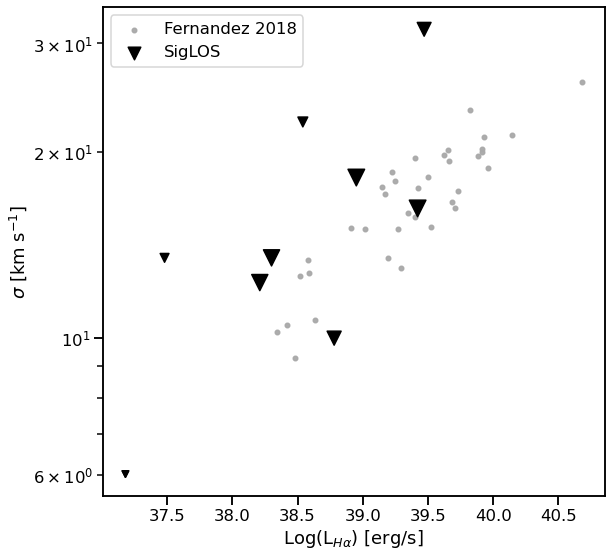

In [157]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Fer.L,10**(Fer.sig),label='Fernandez 2018',marker='.',alpha=0.95,color='darkgray')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


Older Data

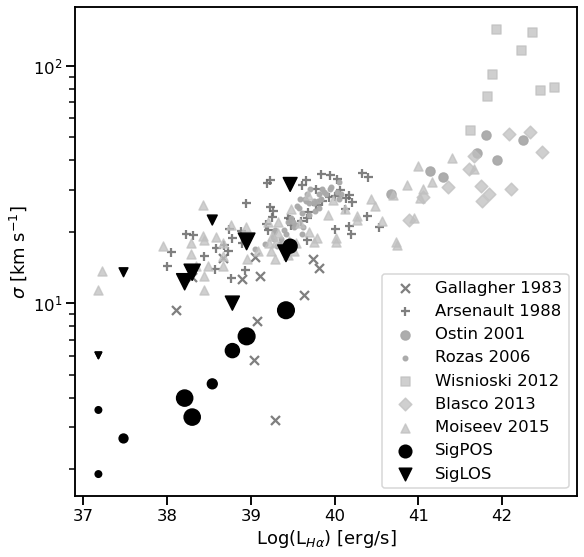

In [158]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


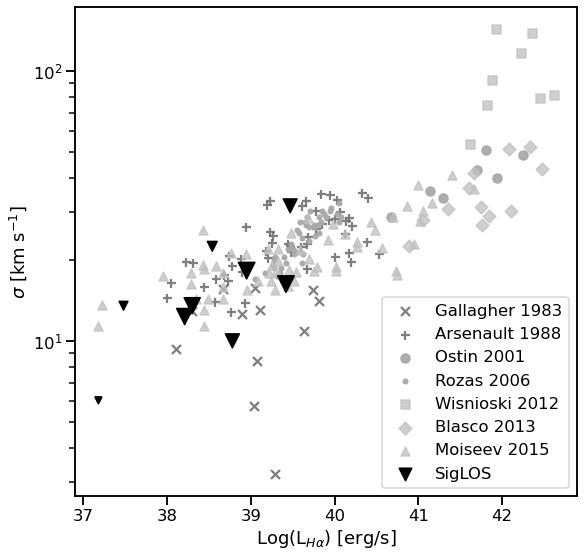

In [159]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')

In [160]:
globalL= pd.concat([Moiseev.L, Ostin.L.dropna(),Blasco.L.dropna(),Rozas.L.dropna(),Ars.L.dropna(),Wis.L.dropna(),Gal.L.dropna()], axis=0)
globalS= pd.concat([Moiseev.sig, Ostin.sig.dropna(),Blasco.sig.dropna(),10**Rozas.sig.dropna(),10**Ars.sig.dropna(),Wis.sig.dropna(),Gal.sig.dropna()],  axis=0)
GL=np.concatenate((np.array(globalL), np.array(logdata['log L(H) [erg s^-1]'])))
GS=np.concatenate((np.array(globalS), np.array(10**(logdata['log siglos [km/s]']))))

In [161]:
GSer = (GS*.05)/GS

In [162]:
GLer = (GL*.05)/GL

In [163]:
X, Xe, Y, Ye = [GL, GLer, np.log10(GS), GSer]

In [164]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [165]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99302298 0.99279898 0.993358   1.00977903 0.99649354 0.99264979]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00365067 1.00385398 1.01598816 1.00408779 0.99540909 1.00310114]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00053267 1.0005294  1.00565336 1.00714817 0.99686553 0.99768632]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00240398 1.00244106 1.00683879 1.01163937 0.99936522 0.99799077]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00422109 1.00409586 1.00237414 1.01211799 0.99967988 0.9980493 ]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00187864 1.00184193 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00002448 1.00002021 1.00013505 1.00266854 1.00014145 0.9999815 ]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998602 0.9999822  1.0000715  1.00275153 1.00015011 0.99995199]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00002293 1.00001883 1.00005381 1.00271612 1.00021205 0.99997806]


In [166]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [167]:
#dfchain.describe()

In [168]:
pearsonr(X, Y)

(0.7721434710554228, 1.2072429194900767e-41)

In [169]:
a = pearsonr(X, Y)

In [170]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,204.000000,2.040000e+02,204.000000,2.040000e+02
mean,39.738039,5.000000e-02,1.359588,5.000000e-02
std,1.110737,4.879636e-17,0.210109,4.875989e-17
min,37.170000,5.000000e-02,0.506911,5.000000e-02
25%,39.079250,5.000000e-02,1.252489,5.000000e-02
50%,39.617450,5.000000e-02,1.349277,5.000000e-02
75%,40.148700,5.000000e-02,1.460000,5.000000e-02
max,42.622000,5.000000e-02,2.153357,5.000000e-02


[Text(0, 0.5, 'log $\\sigma$ [km/s]'), Text(0.5, 0, 'log L(H) [erg s^-1]')]

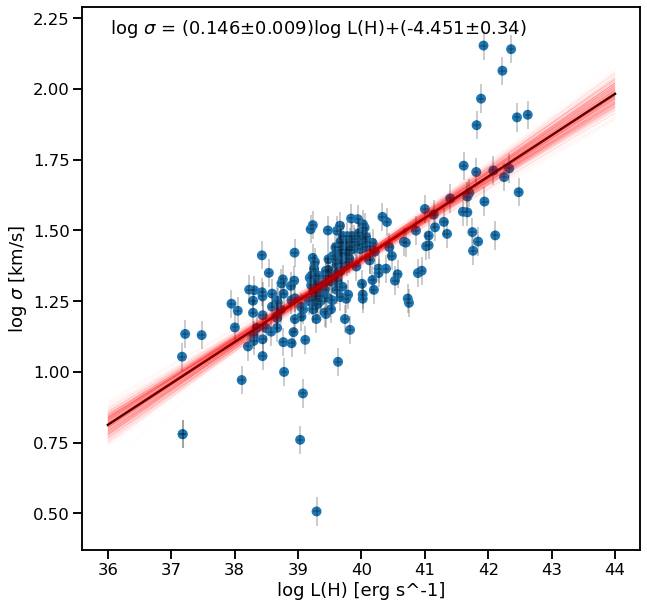

In [171]:
vmin, vmax = 36, 44
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log L(H)+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log L(H) [erg s^-1]", ylabel=r"log $\sigma$ [km/s]",
)

In [172]:
samples

,0
0,N604H
1,N595
2,HX
3,HV
4,Dor
5,CarC
6,N346
7,M8
8,OrionLH
9,OrionS


In [173]:
i=0
r = CI[samples[0][i]]['r']
B = CI[samples[0][i]]['B']
#mask = r < 2
sig2 = np.round(CI[samples[0][i]]['result_emcee'].params['sig2'].value,4)
sig2, 2*sig2, r, B

(96.9035,
 193.807,
 array([  1.05883308,   1.49564148,   2.11264974,   2.98419708,
          3.34832419,   3.75688154,   4.21529041,   4.72963363,
          5.30673622,   5.95425597,   6.68078508,   7.49596415,
          8.41061011,   9.43685975,  10.5883308 ,  11.88030255,
         13.32991871,  14.95641478,  16.7813734 ,  18.82901064,
         21.12649741,  23.70431997,  26.59668446,  29.84197078,
         33.48324193,  37.56881536,  42.15290414,  47.29633635,
         53.0673622 ,  59.54255971,  66.80785081,  74.9596415 ,
         84.10610109,  94.36859755, 105.88330795, 118.80302553,
        133.29918707, 149.56414783, 167.81373397, 188.2901064 ,
        211.26497415]),
 array([  1.9057852 ,   3.90697386,   7.22286646,  10.77812435,
         13.0882077 ,  15.92913646,  19.21371115,  23.54610268,
         27.20101652,  31.13620186,  36.20295249,  41.30566367,
         45.59065752,  50.94841821,  56.15964192,  61.42218977,
         65.31502511,  69.05821626,  71.95048586,  74.748558

print("--- %s seconds ---" % (time.time()-start_time))
